In [7]:
import tensorflow as tf
#from tensorflow.keras.utils import get_custom_objects
#from tensorflow.keras.layers import Activation

def fourier_activation_lambda(freq):
    fn = lambda x : tf.sin(freq*x)
    return(fn)

freq = 1.0
fourier = fourier_activation_lambda(freq)

custom_objects = tf.keras.utils.get_custom_objects()

custom_objects["fourier"] = tf.keras.layers.Activation(fourier)

print(custom_objects)
print(3*"\n")
print(f"After addition: {tf.keras.utils.get_custom_objects()=}")

x_input = tf.keras.Input(shape=[5])
layer_2 = tf.keras.layers.Dense(100, input_shape = [5],
                                activation="fourier",
                                )(x_input)

model = tf.keras.Model(inputs=x_input, outputs=layer_2)
model.compile(optimizer='adam', loss='mse')
model.summary()

{'fourier': <Activation name=activation_4, built=False>}




After addition: tf.keras.utils.get_custom_objects()={'fourier': <Activation name=activation_4, built=False>}


ValueError: Could not interpret activation function identifier: fourier

In [1]:
!nvidia-smi

Sun Sep 22 16:56:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070        Off | 00000000:17:00.0 Off |                  N/A |
| 36%   32C    P8               6W / 151W |     86MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf

L = tf.keras.layers
M = tf.keras.models

2024-09-22 16:56:41.461393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 16:56:41.471284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 16:56:41.483218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 16:56:41.486905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 16:56:41.495735: I tensorflow/core/platform/cpu_feature_guar

# NETWORKS DEFINITION

## PNET

In [3]:
tf.keras.Layer

keras.src.layers.layer.Layer

In [4]:
def build_pnet(permutations=True):
    inp = L.Input((None, None, 3), name="input1")

    layer = L.Permute((2, 1, 3))(inp) if permutations else inp
    layer = L.Conv2D(10, kernel_size=(3,3), strides=(1,1), padding="valid", activation="linear", name="conv1")(layer)
    layer = L.PReLU(shared_axes=[1, 2], name="prelu1")(layer)
    layer = L.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="maxpooling1")(layer)
        
    layer = L.Conv2D(16, kernel_size=(3,3), strides=(1,1), padding="valid", activation="linear", name="conv2")(layer)
    layer = L.PReLU(shared_axes=[1, 2], name="prelu2")(layer)
    
    layer = L.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding="valid", activation="linear", name="conv3")(layer)
    layer_middle = L.PReLU(shared_axes=[1, 2], name="prelu3")(layer)
    
    layer_out1 = L.Conv2D(4, kernel_size=(1,1), strides=(1,1), padding="valid", activation="linear", name="conv4-1")(layer_middle)
    layer_out1 = L.Permute((2, 1, 3))(layer_out1) if permutations else layer_out1
    
    layer_out2 = L.Conv2D(2, kernel_size=(1,1), strides=(1,1), padding="valid", activation="softmax", name="conv4-2")(layer_middle)
    layer_out2 = L.Permute((2, 1, 3))(layer_out2) if permutations else layer_out2
    
    pnet = M.Model(inp, [layer_out1, layer_out2])
    return pnet

pnet = build_pnet(permutations=False)
pnet.summary()

2024-09-22 16:56:42.906469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45892 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-09-22 16:56:42.906933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7445 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:17:00.0, compute capability: 6.1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, None,      │        280 │ input1[0][0]      │
│                     │ None, 10)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu1 (PReLU)      │ (None, None,      │         10 │ conv1[0][0]       │
│                     │ None, 10)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpooling1         │ (None, None,      │          0 │ prelu1[0][0]      │
│ (MaxPooling2D)      │ None, 10)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, None,      │      1,456 │ maxpooling1[0][0] │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu2 (PReLU)      │ (None, None,      │         16 │ conv2[0][0]       │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, None,      │      4,640 │ prelu2[0][0]      │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu3 (PReLU)      │ (None, None,      │         32 │ conv3[0][0]       │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv4-1 (Conv2D)    │ (None, None,      │        132 │ prelu3[0][0]      │
│                     │ None, 4)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv4-2 (Conv2D)    │ (None, None,      │         66 │ prelu3[0][0]      │
│                     │ None, 2)          │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,632 (25.91 KB)

 Trainable params: 6,632 (25.91 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
len(pnet.layers)

10

## RNET

In [28]:
inp = L.Input((24, 24, 3), name="input1")

layer = L.Conv2D(28, kernel_size=(3,3), strides=(1,1), padding="valid", activation="linear", name="conv1")(inp)
layer = L.PReLU(shared_axes=[1, 2], name="prelu1")(layer)
layer = L.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same", name="maxpooling1")(layer)

layer = L.Conv2D(48, kernel_size=(3,3), strides=(1,1), padding="valid", activation="linear", name="conv2")(layer)
layer = L.PReLU(shared_axes=[1, 2], name="prelu2")(layer)
layer = L.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid", name="maxpooling2")(layer)

layer = L.Conv2D(64, kernel_size=(2,2), strides=(1,1), padding="valid", activation="linear", name="conv3")(layer)
layer = L.PReLU(shared_axes=[1, 2], name="prelu3")(layer)
layer = L.Permute((2, 1, 3), name="permute")(layer)
layer = L.Flatten(name="flatten3")(layer)

layer = L.Dense(128, activation="linear", name="fc4")(layer)
layer_middle = L.PReLU(name="prelu4")(layer)

layer_out1 = L.Dense(4, activation="linear", name="fc5-1")(layer_middle)
layer_out2 = L.Dense(2, activation="softmax", name="fc5-2")(layer_middle)

rnet = M.Model(inp, [layer_out1, layer_out2])
rnet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 24, 24, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 22, 22,    │        784 │ input1[0][0]      │
│                     │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu1 (PReLU)      │ (None, 22, 22,    │         28 │ conv1[0][0]       │
│                     │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpooling1         │ (None, 11, 11,    │          0 │ prelu1[0][0]      │
│ (MaxPooling2D)      │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 9, 9, 48)  │     12,144 │ maxpooling1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu2 (PReLU)      │ (None, 9, 9, 48)  │         48 │ conv2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpooling2         │ (None, 4, 4, 48)  │          0 │ prelu2[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 3, 3, 64)  │     12,352 │ maxpooling2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu3 (PReLU)      │ (None, 3, 3, 64)  │         64 │ conv3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 3, 3, 64)  │          0 │ prelu3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten3 (Flatten)  │ (None, 576)       │          0 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc4 (Dense)         │ (None, 128)       │     73,856 │ flatten3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu4 (PReLU)      │ (None, 128)       │        128 │ fc4[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc5-1 (Dense)       │ (None, 4)         │        516 │ prelu4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc5-2 (Dense)       │ (None, 2)         │        258 │ prelu4[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,178 (391.32 KB)

 Trainable params: 100,178 (391.32 KB)

 Non-trainable params: 0 (0.00 B)

## ONet

In [29]:
inp = L.Input((48, 48, 3))

layer = L.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding="valid", activation="linear", name="conv1")(inp)
layer = L.PReLU(shared_axes=[1, 2], name="prelu1")(layer)
layer = L.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same", name="maxpooling1")(layer)

layer = L.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="valid", activation="linear", name="conv2")(layer)
layer = L.PReLU(shared_axes=[1, 2], name="prelu2")(layer)
layer = L.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid", name="maxpooling2")(layer)

layer = L.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="valid", activation="linear", name="conv3")(layer)
layer = L.PReLU(shared_axes=[1, 2], name="prelu3")(layer)
layer = L.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="maxpooling3")(layer)

layer = L.Conv2D(128, kernel_size=(2,2), strides=(1,1), padding="valid", activation="linear", name="conv4")(layer)
layer = L.PReLU(shared_axes=[1, 2], name="prelu4")(layer)
layer = L.Permute((2, 1, 3), name="permute")(layer)
layer = L.Flatten(name="flatten4")(layer)
#layer = L.Lambda(lambda x: tf.reshape(x, (-1, tf.math.cumprod(tf.shape(x[0]))[-1])), name="flatten4")(layer)

layer = L.Dense(256, activation="linear", name="fc5")(layer)
layer_middle = L.PReLU(name="prelu5")(layer)

layer_out1 = L.Dense(4, activation="linear", name="fc6-2")(layer_middle)
layer_out2 = L.Dense(10, activation="linear", name="fc6-3")(layer_middle)
layer_out3 = L.Dense(2, activation="softmax", name="fc6-1")(layer_middle)

onet = M.Model(inp, [layer_out1, layer_out2, layer_out3])
onet.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 46, 46,    │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu1 (PReLU)      │ (None, 46, 46,    │         32 │ conv1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpooling1         │ (None, 23, 23,    │          0 │ prelu1[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 21, 21,    │     18,496 │ maxpooling1[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu2 (PReLU)      │ (None, 21, 21,    │         64 │ conv2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpooling2         │ (None, 10, 10,    │          0 │ prelu2[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 8, 8, 64)  │     36,928 │ maxpooling2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu3 (PReLU)      │ (None, 8, 8, 64)  │         64 │ conv3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpooling3         │ (None, 4, 4, 64)  │          0 │ prelu3[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv4 (Conv2D)      │ (None, 3, 3, 128) │     32,896 │ maxpooling3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu4 (PReLU)      │ (None, 3, 3, 128) │        128 │ conv4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 3, 3, 128) │          0 │ prelu4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten4 (Flatten)  │ (None, 1152)      │          0 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc5 (Dense)         │ (None, 256)       │    295,168 │ flatten4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prelu5 (PReLU)      │ (None, 256)       │        256 │ fc5[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc6-2 (Dense)       │ (None, 4)         │      1,028 │ prelu5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc6-3 (Dense)       │ (None, 10)        │      2,570 │ prelu5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc6-1 (Dense)       │ (None, 2)         │        514 │ prelu5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 389,040 (1.48 MB)

 Trainable params: 389,040 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

## Weights adaptation

In [30]:
import numpy as np

In [31]:
weights = np.load("mtcnn_weights.npy", allow_pickle=True)[True][0]

In [32]:
def offload_weights(weights_dict, order=None, broadcast_shapes=None):
    result = []
    if order is None:
        order = list(weights_dict.keys())

    if broadcast_shapes is None:
        broadcast_shapes = []
    
    for k in order:
        v = weights_dict[k]
        
        for sub_k, sub_v in v.items():
            result.append(sub_v)

    for i, shape in enumerate(broadcast_shapes):
        result[i] = np.broadcast_to(result[i], shape)
        
    return result

In [35]:
pnet_weights = offload_weights(weights['PNet'], 
                               order=["conv1", "prelu1", "conv2", "prelu2", "conv3", "prelu3", "conv4-2", "conv4-1"],
                               broadcast_shapes=[w.shape for w in pnet.get_weights()])

In [36]:
rnet_weights = offload_weights(weights['RNet'], 
                               order=["conv1", "prelu1", "conv2", "prelu2", "conv3", "prelu3", "fc1", "prelu4", "fc2-2", "fc2-1"],
                               broadcast_shapes=[w.shape for w in rnet.get_weights()])


In [37]:
onet_weights = offload_weights(weights['ONet'], 
                               order=["conv1", "prelu1", "conv2", "prelu2", "conv3", "prelu3", "conv4", "prelu4", "fc1", "prelu5", "fc2-2", "fc2-3", "fc2-1"],
                               broadcast_shapes=[w.shape for w in onet.get_weights()])

In [38]:
for l in pnet.layers:
    w = l.get_weights()
    if type(w) is list:
        print(l.name, " - ", [lw.shape for lw in w])
    else:
        print(l.name, " - ", w.shape)

input1  -  []
conv1  -  [(3, 3, 3, 10), (10,)]
prelu1  -  [(1, 1, 10)]
maxpooling1  -  []
conv2  -  [(3, 3, 10, 16), (16,)]
prelu2  -  [(1, 1, 16)]
conv3  -  [(3, 3, 16, 32), (32,)]
prelu3  -  [(1, 1, 32)]
conv4-1  -  [(1, 1, 32, 4), (4,)]
conv4-2  -  [(1, 1, 32, 2), (2,)]


In [39]:
pnet.set_weights(pnet_weights)
rnet.set_weights(rnet_weights)
onet.set_weights(onet_weights)

## Permuting filter's weights
Weights of the filters were permuted by an author mistake during the training stage. This forces the author to transpose width and height dimensions every time he needs to process an image.

We can easily fix this issue by permuting each conv weights, so the need for permutations during inference is not required, resulting in a speedup of the process. Also, the code becomes more readable.

### PNET PERMUTATION

In [40]:
def permute_weights(net):
    for layer in net.layers:
        if 'conv' in layer.name and isinstance(layer, L.Conv2D):
            _weights = layer.get_weights()
    
            if len(_weights) > 0:
                kernel_weights = _weights[0]  # [kernel_height, kernel_width, in_channels, out_channels]
                kernel_weights_inverted = np.transpose(kernel_weights, (1, 0, 2, 3))  # Intercambia altura y ancho
                layer.set_weights([kernel_weights_inverted, _weights[1] if len(_weights) > 1 else None])

In [41]:
permute_weights(pnet)
permute_weights(rnet)
permute_weights(onet)

In [31]:
"""for layer in pnet.layers:
    if 'conv' in layer.name and isinstance(layer, L.Conv2D):
        _weights = layer.get_weights()

        if len(_weights) > 0:
            kernel_weights = _weights[0]  # [kernel_height, kernel_width, in_channels, out_channels]
            kernel_weights_inverted = np.transpose(kernel_weights, (1, 0, 2, 3))  # Intercambia altura y ancho
            layer.set_weights([kernel_weights_inverted, _weights[1] if len(_weights) > 1 else None])
"""            

"for layer in pnet.layers:\n    if 'conv' in layer.name and isinstance(layer, L.Conv2D):\n        _weights = layer.get_weights()\n\n        if len(_weights) > 0:\n            kernel_weights = _weights[0]  # [kernel_height, kernel_width, in_channels, out_channels]\n            kernel_weights_inverted = np.transpose(kernel_weights, (1, 0, 2, 3))  # Intercambia altura y ancho\n            layer.set_weights([kernel_weights_inverted, _weights[1] if len(_weights) > 1 else None])\n"

## Weights storage

In [42]:
import joblib

In [43]:
joblib.dump(pnet.get_weights(), 'mtcnn/assets/weights/pnet.lz4', compress=("lz4", 1))
joblib.dump(rnet.get_weights(), 'mtcnn/assets/weights/rnet.lz4', compress=("lz4", 1))
joblib.dump(onet.get_weights(), 'mtcnn/assets/weights/onet.lz4', compress=("lz4", 1))

['mtcnn/assets/weights/onet.lz4']

In [17]:
joblib.dump({'pnet': pnet.get_weights(), 'rnet': rnet.get_weights(), 'onet': onet.get_weights()}, "mtcnn_weights.jbl", compress=("lz4", 1))

['mtcnn_weights.jbl']

# DEBUG

## IMAGE GENERATION

In [18]:
import cv2

In [19]:
target_filenames = ["0038_02.jpg", "ivan.jpg"]

In [20]:
import matplotlib.pyplot as plt

In [21]:
%%time
images = [cv2.imread(filename)[:,:,::-1] for filename in target_filenames]

CPU times: user 4.7 ms, sys: 65 μs, total: 4.77 ms
Wall time: 3.76 ms


In [22]:
min_face_size = 20
steps_threshold = [0.6, 0.7, 0.7]
scale_factor = 0.709

In [23]:
height = 1000
width = 2000

In [24]:
img = images[0]
imgs = images

In [25]:
def build_scale_pyramid(width, height, min_face_size, scale_factor, min_size=12):
    min_dim = min(width, height)
    scales_count = round(-((np.log(min_dim / min_size) / np.log(scale_factor)) + 1))
    m = min_size / min_face_size
    
    return m * scale_factor ** np.arange(scales_count)

In [26]:
import cv2

def scale_images(images, scale: float):
    height, width = images.shape[-3:-1]
    width_scaled = int(np.ceil(width * scale))
    height_scaled = int(np.ceil(height * scale))

    images_scaled = tf.image.resize(images, (height_scaled, width_scaled), method=tf.image.ResizeMethod.AREA)
    
    return images_scaled

def normalize_images(images):
    return (images - 127.5) * 0.0078125

In [27]:
def process(images, pipeline):
    result = images
    
    for pipe in pipeline:
        result = pipe['function'](result, **pipe.get('kwargs',{}))
        
    return result

In [28]:
def transpose_coords(images):
    shape = images.shape
    axes_order = np.arange(len(shape))
    axes_order[-2] = len(shape)-3
    axes_order[-3] = len(shape)-2
    
    return np.transpose(images, axes_order)

In [29]:
scales = [build_scale_pyramid(img.shape[1], img.shape[0], min_face_size, scale_factor) for img in imgs]

In [30]:
def pad_stack(images, justification="center"):
    sizes_stack = np.stack([img.shape for img in images], axis=0)
    sizes_max = sizes_stack.max(axis=0, keepdims=True)
    sizes_diff = sizes_max - sizes_stack
    sizes_mod = sizes_diff % 2
    sizes_diff = sizes_diff - sizes_mod
    
    justification_mask = {
        "top": np.asarray([[[0, 1], [0.5, 0.5], [0, 0]]]),
        "topleft": np.asarray([[[0, 1], [0, 1], [0, 0]]]),
        "topright": np.asarray([[[0, 1], [1, 0], [0, 0]]]),
        
        "bottom": np.asarray([[[1, 0], [0.5, 0.5], [0, 0]]]),
        "bottomleft": np.asarray([[[1, 0], [0, 1], [0, 0]]]),
        "bottomright": np.asarray([[[1, 0], [1, 0], [0, 0]]]),
        
        "left": np.asarray([[[0.5, 0.5], [0, 1], [0, 0]]]),
        "right": np.asarray([[[0.5, 0.5], [1, 0], [0, 0]]]),
        
        "center": np.asarray([[[0.5, 0.5], [0.5, 0.5], [0, 0]]]),
    }
    
    justification_pad_mask = {
        "top": "topleft",
        "bottom": "bottomleft",
        "left": "topleft",
        "right": "topright",
        "center": "topleft"
    }
    
    pad_mask = justification_mask[justification]
    mod_mask = justification_mask[justification_pad_mask.get(justification, justification)]
    
    pad_param = (pad_mask * sizes_diff[:,:,None] + mod_mask * sizes_mod[:,:,None]).astype(int)

    images_padded = np.stack([np.pad(img, pad) for img, pad in zip(images, pad_param)], axis=0)
    return images_padded

def ensure_stack(images):
    if isinstance(images, list):
        images = pad_stack(images)
    
    return np.broadcast_to(images, [(len(images.shape)<4) + (len(images.shape)>=4) * images.shape[0],] + list(images.shape[len(images.shape)>=4:]))

In [31]:
pipeline = [
    {'function': scale_images, 'kwargs': {"scale":0.7}},
    {'function': normalize_images, 'kwargs': {}},
    #{'function': transpose_coords, 'kwargs': {}}
]
images_scaled = process(ensure_stack(img), pipeline)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99609375..0.99610126].


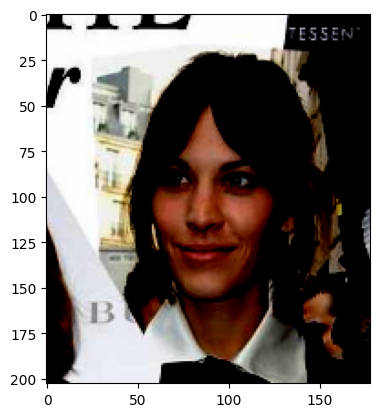

In [32]:
plt.imshow(images_scaled[0])

In [33]:
scales

[array([0.6       , 0.4254    , 0.3016086 , 0.2138405 , 0.15161291,
        0.10749356, 0.07621293, 0.05403497]),
 array([0.6       , 0.4254    , 0.3016086 , 0.2138405 , 0.15161291,
        0.10749356, 0.07621293, 0.05403497, 0.03831079, 0.02716235])]

## PNET prediction

In [34]:
# 1. We take the input images and we pad to the biggest


In [35]:
r = pnet(normalize_images(scale_images(ensure_stack(img), 0.7)))

2024-09-18 00:34:37.815087: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1726619677.867218  192913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726619677.884526  192913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726619677.885060  192913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726619677.904728  192913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726619677.906098  192913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726619677.907354  192913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726619677.907732  192913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726619677.908106  192913 gpu_t

In [36]:

r

[<tf.Tensor: shape=(1, 97, 84, 4), dtype=float32, numpy=
 array([[[[ 7.32030720e-02, -1.67948008e-03,  1.55734301e-01,
            2.80358434e-01],
          [-3.06192227e-03, -3.88794020e-03,  1.40030921e-01,
            3.53747129e-01],
          [ 1.36013851e-01, -9.74214450e-03,  5.46535775e-02,
            1.94367379e-01],
          ...,
          [ 1.13436114e-02, -9.66800973e-02, -1.07657947e-02,
            1.06440350e-01],
          [ 5.35892062e-02, -6.47406206e-02, -6.23895973e-03,
            1.15913227e-01],
          [ 3.08644809e-02, -7.44212419e-02,  1.90052986e-02,
            1.30906120e-01]],
 
         [[ 6.97101802e-02, -6.48879036e-02,  1.09180011e-01,
            1.78931028e-01],
          [ 1.29153887e-02, -6.30406439e-02,  1.30564123e-01,
            2.76542276e-01],
          [ 6.15201704e-02, -1.13333538e-02,  2.92448625e-02,
            2.50712812e-01],
          ...,
          [ 5.54543510e-02, -2.28829682e-02,  1.98694989e-02,
            1.82986662e-01],


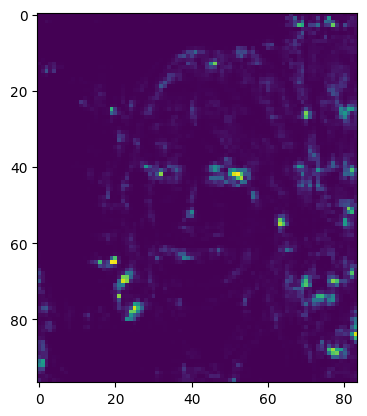

In [37]:
plt.imshow(r[1][0,:,:,1])

In [38]:
scale = scales[0]
threshold_face = steps_threshold[0]

In [43]:
result = pnet(np.concatenate([images_scaled, images_scaled], axis=0))

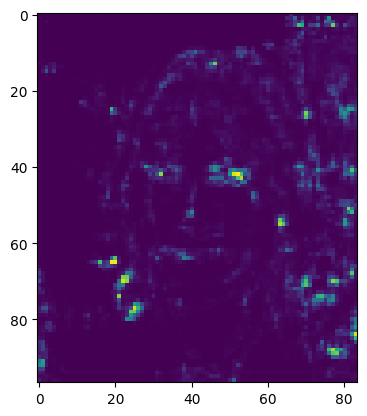

In [40]:
plt.imshow(result[0][1][0,:,:,1])

In [41]:
def generate_bounding_box(bbox_reg, bbox_class, threshold_face, strides=2, cell_size=12):
    detection_mask = (bbox_class[:,:,:,1:2] > threshold_face).numpy()
    
    detection_tensor = np.concatenate([
        detection_mask,
        bbox_class[:,:,:,1:2].numpy() * detection_mask,
        bbox_reg.numpy() * detection_mask
    ], axis=-1)
    
    index_bboxes = np.stack(np.where(detection_tensor[:,:,:,0] == 1))
    
    strides = np.asarray([[1], [strides], [strides]])
    cellsize = [np.asarray([[0], [1], [1]]), np.asarray([[0], [cell_size], [cell_size]])]
    
    bbox_up_left = index_bboxes * strides + cellsize[0]
    bbox_bottom_right = index_bboxes * strides + cellsize[1]
    
    bboxes_result = np.concatenate([
        bbox_up_left.T,
        bbox_bottom_right[1:].T,
        detection_tensor[index_bboxes[0], index_bboxes[1], index_bboxes[2]]
    ], axis=-1)

    return bboxes_result

def upscale_bboxes(bboxes_result, scales):
    scales_bcast = np.expand_dims(scales[bboxes_result[:,0].astype(int)], axis=-1)
    bboxes_result[:,1:5] = np.fix(bboxes_result[:,1:5] / scales_bcast)
    return bboxes_result

In [44]:
bbox_reg, bbox_class = result

In [45]:
%%time
a = generate_bounding_box(bbox_reg, bbox_class, threshold_face=threshold_face)
b = upscale_bboxes(a, np.asarray([0.7, 0.7]))

CPU times: user 8.14 ms, sys: 3.61 ms, total: 11.7 ms
Wall time: 9.78 ms


In [47]:
b[0]

array([ 0.00000000e+00,  1.00000000e+01,  1.95000000e+02,  2.50000000e+01,
        2.11000000e+02,  1.00000000e+00,  6.89244330e-01,  1.16440475e-01,
        5.87825440e-02, -3.59483287e-02,  5.98944910e-02])

In [989]:
import numpy as np

def iou(bboxes, method="union"):
    """
    Performs Intersection over Union (IoU) based on the method (Union or Min).
    :param bboxes: List of bounding boxes in format [row1, col1, row2, col2]
    :param method: method to apply, either "union" or "min"
    :return: IoU matrix of shape (N, N)
    """
    # Convert the list of bboxes to a numpy array
    bboxes = np.stack(bboxes, axis=0)
    
    # Calculate the area of each bbox once
    area_bboxes = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])
    
    # Expand dimensions for broadcasting to compute pairwise IoU
    bboxes_a = np.expand_dims(bboxes, axis=0)
    bboxes_b = np.expand_dims(bboxes, axis=1)

    # Calculate the intersection coordinates (rows and columns)
    row_inter_top = np.maximum(bboxes_a[:, :, 0], bboxes_b[:, :, 0])
    col_inter_left = np.maximum(bboxes_a[:, :, 1], bboxes_b[:, :, 1])
    row_inter_bottom = np.minimum(bboxes_a[:, :, 2], bboxes_b[:, :, 2])
    col_inter_right = np.minimum(bboxes_a[:, :, 3], bboxes_b[:, :, 3])

    # Compute width and height of the intersection
    height_inter = np.maximum(0, row_inter_bottom - row_inter_top)
    width_inter = np.maximum(0, col_inter_right - col_inter_left)

    # Calculate area of the intersection
    area_inter = width_inter * height_inter

    if method == "union":
        area_union = area_bboxes[:, None] + area_bboxes[None, :] - area_inter
        iou_matrix = area_inter / area_union
    elif method == "min":
        area_min = np.minimum(area_bboxes[:, None], area_bboxes[None, :])
        iou_matrix = area_inter / area_min
    else:
        raise ValueError("Method should be either 'union' or 'min'.")

    return iou_matrix

def sort_by_scores(tensor, scores, ascending=True):
    """
    Sorts the elements of a tensor based on the floating-point scores in ascending order.
    
    :param tensor: Tensor of shape (N, ...) where N is the number of elements to be sorted.
    :param scores: Array of scores of shape (N,) corresponding to each element in the tensor.
    :param ascending: True to sort in ascending order (first small, last big); False otherwise.
    :return: Sorted tensor based on the scores in ascending order.
    """
    sorted_indices = np.argsort(scores)
    sorted_tensor = tensor[sorted_indices[::(-2 * int(not(ascending)) + 1)]]
    
    return sorted_tensor

def nms(target_iou, threshold):
    # 1. Compute the allowed slots (upper side of the triangle, above diagonal)
    allowed_mask = np.triu(np.ones((target_iou.shape[0], target_iou.shape[0])), k=1)

    # 2. Compute the slots that are invalid
    failed_mask = (target_iou > threshold).astype(int)

    # 3. Apply masks and get index
    result_indexes = np.asarray([], dtype="float32") if failed_mask.sum() == np.cumprod(failed_mask.shape)[-1] else np.where((failed_mask * allowed_mask).sum(axis=0) == 0)[0]

    return result_indexes  

def smart_nms_from_bboxes(bboxes, threshold, method="union"):
    # bboxes must have the following shape: (image_id, row1, col1, row2, col2, score)
    bboxes = sort_by_scores(bboxes, scores=bboxes[:,6], ascending=False)
    image_ids = np.unique(bboxes[:,0])

    result = {}
    
    for image_id in image_ids:
        target_bboxes = bboxes[bboxes[:,0] == image_id]
        target_iou = iou(target_bboxes[:,1:5], method=method) 
        target_indexes = nms(target_iou, threshold)
        result[image_id] = target_indexes
    
    return result


In [995]:
smart_nms_from_bboxes(b, threshold_face, method="union")

{0.0: array([0]), 1.0: array([0])}

In [1010]:
np.empty((0, 9))

array([], shape=(0, 9), dtype=float64)